# Impact of Result Count on Latency
In addition to the time taken to calculate distances between a query vector and all of the reference vectors, there is a very small amount of time added for each result that must be returned by the hardware (about 20us per result).

In this notebook we'll perform an experiment using the MNIST dataset to determine the relationship between the number of results returned in a distance threshold query with the total latency of the query. For instance, how much slower is a query that returns 1,000 results versus a query that returns only a single result?

First, we need to establish a connection to the Nearist appliance, set the results filtering mode, and load our local query vectors. 

_Make sure to fill in your API key, server IP address, etc._

In [7]:
from __future__ import division

import Client
import Common

import h5py
import time
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

# IMPORTANT - Fill in these configuration values.
path_to_local_dataset = '../MNIST/data/X_test_uint8.h5'
api_key = ""
ip_addr = ""
port = -1

print 'Connecting to Nearist board...'
sys.stdout.flush()

# Open the connection to the server.
c = Client.Client()
c.open(ip_addr, port, api_key)

print '    Connection successful.'
sys.stdout.flush()

# Use L1 distance.
c.set_distance_mode(Common.DistanceMode.L1)

# For thresholded L1 distance, we use the less-than mode.
c.set_query_mode(Common.QueryMode.LT)

# Load query vectors on your machine.
print '\nLoading local query vectors...'
sys.stdout.flush()

h5f = h5py.File(path_to_local_dataset, 'r')
X_test = h5f['X_test'][:]

Connecting to Nearist board...
    Connection successful.

Loading local query vectors...


### Dataset Load
Load the dataset, which is already present on the hard disk of the remote server. 
Note that you only need to do this once, and can skip this step if the dataset is already loaded.

In [8]:
print '\nStarting remote load of dataset...'
sys.stdout.flush()

# Load 56.3 MB dataset already on Nearist server
t0 = time.time()

# Reset the appliance timer.    
c.reset_timer()

c.load_dataset_file(file_name='/nearist/MNIST/X_train_uint8.h5', dataset_name='X_train')

# Get the elapsed appliance time. Convert from nanoseconds to seconds.
appliance_time_s = c.get_timer_value() / 10**9     

elapsed = time.time() - t0

print 'Dataset load speed:'
print '   Total time: %.1f seconds' % elapsed
print '   Appliance time: %.1f seconds (%.2f MB / second)' % (appliance_time_s, (56.3 / appliance_time_s))
sys.stdout.flush()



Starting remote load of dataset...
Dataset load speed:
   Total time: 17.8 seconds
   Appliance time: 16.7 seconds (3.38 MB / second)


### Measure Query Latencies
We'll perform a handful of queries with different threshold values, and record both the "appliance time" (the time required by the Nearist appliance, without the internet overhead) and the "wall time" (the total elapsed time, including internet overhead). 
We've previously identified a number of specific query vectors from this dataset which return results at these threshold values.

In [14]:
result_counts = []
appliance_times = []
wall_times = []

# These are some specific query vectors which have results in these threshold 
# ranges.
for i in [0, 2, 5, 14, 29, 31, 39, 40, 57, 74, 83, 89]:

    # Get the query vector.
    test_vec = X_test[i].tolist()

    print '\n========= Query %d =========' % i
    sys.stdout.flush()
    
    # Try different threshold values.
    for threshold in [5000, 6000, 7000, 8000, 9000]:
        
        c.set_threshold(threshold)
        
        t0 = time.time()
        
        # Reset the appliance timer.    
        c.reset_timer()
    
        # Submit the query
        results = c.query(test_vec)
        
        # Calculate the total elapsed time in miliseconds.
        wall_time_ms = (time.time() - t0) * 1000
        
        # Get the elapsed appliance time. Convert from nanoseconds to milliseconds.
        appliance_time_ms = c.get_timer_value() / 10**6     

        # Only record data points with at least 1 result.
        if len(results) > 0:    
            print 'At threshold %5d, %4d results, appliance %.0f ms, wall %.0fms' % (threshold, len(results), appliance_time_ms, wall_time_ms)
    
            # Track the timing values.
            result_counts.append(len(results))
            wall_times.append(wall_time_ms)   
            appliance_times.append(appliance_time_ms)


========= Query 0 =========
At threshold  6000,    1 results, appliance 5 ms, wall 115ms
At threshold  7000,    3 results, appliance 5 ms, wall 101ms
At threshold  8000,   21 results, appliance 5 ms, wall 100ms
At threshold  9000,   68 results, appliance 6 ms, wall 106ms

========= Query 2 =========
At threshold  5000,   15 results, appliance 5 ms, wall 116ms
At threshold  6000,   72 results, appliance 6 ms, wall 99ms
At threshold  7000,  164 results, appliance 8 ms, wall 104ms
At threshold  8000,  352 results, appliance 12 ms, wall 112ms
At threshold  9000,  703 results, appliance 21 ms, wall 138ms

========= Query 5 =========
At threshold  5000,   19 results, appliance 5 ms, wall 110ms
At threshold  6000,   70 results, appliance 6 ms, wall 97ms
At threshold  7000,  211 results, appliance 10 ms, wall 114ms
At threshold  8000,  436 results, appliance 13 ms, wall 115ms
At threshold  9000,  788 results, appliance 23 ms, wall 134ms

========= Query 14 =========
At threshold  7000,   12 r

### Analyze Appliance Latency Trend
Plot the time spent on the appliance as a function of result count. This will show us how result count impacts the appliance latency. The seaborn `regplot` function will show the scatter plot and a fitted line.

`regplot` doesn't return the parameters for the fitted line, so we'll use the LinearRegression class from sklearn to calculate the slope and intercept. The intercept is the minimum latency from the appliance due to distance calculations and overhead with 0 results returned. The slope tells us how much latency each additional result adds.

Intercept: 4.69 ms
Slope: 0.022 ms / result


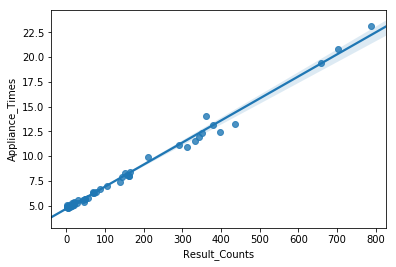

In [15]:
%matplotlib inline

# Plot the result counts and latencies as a scatter plot with a fitted line.
df = pd.DataFrame(
    {'Result_Counts': result_counts,
     'Appliance_Times': appliance_times
    })
    
sns.regplot(x='Result_Counts', y='Appliance_Times', data=df)

# Use the LinearRegression class to estimate the slope and intercept for this
# data.
lr = LinearRegression()
lr.fit(X=np.array(result_counts).reshape(len(result_counts), 1), y=np.array(appliance_times))

# The intercept is essentially a minimum latency for the appliance due to
# overhead. The slope shows the relationship between result count and added
# latency.
print 'Intercept: %.2f ms' % lr.intercept_
print 'Slope: %.3f ms / result' % lr.coef_[0]

### Analyze Internet Overhead
The internet adds additional latency to these queries. The bulk of this overhead is in the ping time, with a small amount added per result transferred back.

Intercept: 95.63 ms
Slope: 0.020 ms / result


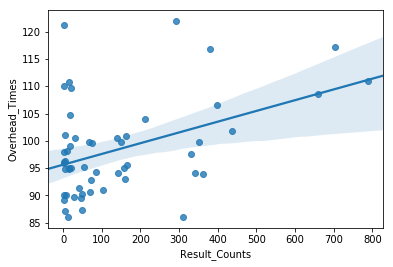

In [16]:
# Subtract the appliance time from the wall time to measure the internet overhead for these queries.
overhead_times = np.array(wall_times) - np.array(appliance_times)

# Plot the result counts and latencies as a scatter plot with a fitted line.
df = pd.DataFrame(
    {'Result_Counts': result_counts,
     'Overhead_Times': overhead_times
    })
    
sns.regplot(x='Result_Counts', y='Overhead_Times', data=df)

# Use the LinearRegression class to estimate the slope and intercept for this
# data.
lr = LinearRegression()
lr.fit(X=np.array(result_counts).reshape(len(result_counts), 1), y=np.array(overhead_times))

# The intercept captures the ping time plus the transfer of the query vector,
# and the slope shows the time added for each additional result transfered back.
print 'Intercept: %.2f ms' % lr.intercept_
print 'Slope: %.3f ms / result' % lr.coef_[0]